In [ ]:
from ray.experimental.serve.frontend import ZMQClient
from multiprocessing import Process
import time

In [ ]:
zmq_client = ZMQClient(port=8083)

In [ ]:
!ray stop

In [ ]:
def noop():
    return 

In [ ]:
latencies = []
for _ in range(3):
    vals = []
    for i in range(0, 501, 10):
        now = time.perf_counter()
        if i == 0:
            zmq_client.query(1.0, 1000, actor="VectorizedAdder")
        for j in range(i):
            zmq_client.query(1.0, 1000, actor="VectorizedAdder")
        after = time.perf_counter()
        print("Trial", i, "Latency:", after-now)
        vals += [after - now]
    latencies += [vals]

In [ ]:
import numpy as np
latencies = np.array(latencies)
latencies

In [ ]:
avg = np.sum(latencies, axis=0)/np.float(3)
xs = np.array(list(np.arange(0, 501, 10)))

In [ ]:
xs[0] = 1
xs

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xs, avg, 'o-')
plt.title("Latency vs. Number of Requests using ZMQ FrontEnd")
plt.xlabel("Number of Queries")
plt.ylabel("Latency in s")
plt.show()

In [ ]:
np.save("lat_zmq.npy", latencies)

In [ ]:
!ray stop

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import requests

import ray
from ray.experimental.serve import DeadlineAwareRouter
from ray.experimental.serve.examples.adder import VectorizedAdder
from ray.experimental.serve.frontend import HTTPFrontendActor
from ray.experimental.serve.router import start_router

ROUTER_NAME = "DefaultRouter"
ray.shutdown()
ray.init()
router = start_router(DeadlineAwareRouter, ROUTER_NAME)
a = HTTPFrontendActor.remote(router=ROUTER_NAME, port=8091)
a.start.remote()

router.register_actor.remote(
    "VAdder", VectorizedAdder, init_kwargs={"scaler_increment": 1})
latencies = []
url = "http://0.0.0.0:8091/VAdder"
payload = {"input": 10, "slo_ms": 1000}
print("Hello")
time.sleep(10)
print("Done sleeping")
for _ in range(3):
    vals = []
    for i in range(0, 501, 10):
        if i == 0:
            now = time.perf_counter()
            resp = requests.post(url, json=payload)
            assert resp.json() == {"success": True, "actor": "VAdder", "result": 11}
            after = time.perf_counter()
        else:
            now = time.perf_counter()
            for j in range(i):
                resp = requests.request("POST", url, json=payload)
                assert resp.json() == {"success": True, "actor": "VAdder", "result": 11}
            after = time.perf_counter()
        print("Trial", i, "Latency:", after-now)
        vals += [after - now]
    latencies += [vals]

In [ ]:
import numpy as np
latencies = np.array(latencies)
np.save("lat_http.npy", latencies)
latencies

In [ ]:
avg = np.sum(latencies, axis=0)/np.float(3)
xs = np.array(list(np.arange(0, 501, 10)))
xs[0] = 1
xs

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xs, avg, 'o-')
plt.title("Latency vs. Number of Requests using HTTP FrontEnd")
plt.xlabel("Number of Queries")
plt.ylabel("Latency in s")

In [ ]:
times = np.load('lat_zmq.npy')
times

In [ ]:
avgt = np.sum(times, axis=0)/np.float(3)
xs = np.array(list(np.arange(0, 501, 10)))
xs[0] = 1
xs

In [ ]:
plt.plot(xs, avg, 'o-', label='HTTP Frontend')
plt.plot(xs, avgt, '+-', label='ZMQ Frontend')
plt.title("Latency vs. Number of Requests")
plt.xlabel("Number of Queries")
plt.ylabel("Latency in s")
plt.legend()

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import requests

import ray
from ray.experimental.serve import DeadlineAwareRouter
from ray.experimental.serve.examples.test import Predictor
from ray.experimental.serve.router import start_router

ray.shutdown()
ray.init()
handle = start_router(DeadlineAwareRouter, "DefaultRouter")


handle.register_actor.remote(
    "Pred", Predictor, init_kwargs={"container": 'ray/example:latest'})
latencies = []
print("hello")
time.sleep(5)
print("Goodbye")
for _ in range(3):
    vals = []
    for i in range(0, 501, 10):
        if i == 0:
            now = time.perf_counter()
            result = handle.call.remote("Pred", [42], time.perf_counter() + 1)
            after = time.perf_counter()
        else:
            now = time.perf_counter()
            for j in range(i):
                result = handle.call.remote("Pred", [42], time.perf_counter() + 1)
            after = time.perf_counter()
        print("Trial", i, "Latency:", after-now)
        vals += [after - now]
    latencies += [vals]

2019-05-08 01:46:40,098	WARNING worker.py:1344 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-05-08 01:46:40,099	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-08_01-46-40_9266/logs.
2019-05-08 01:46:40,205	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:24872 to respond...


2019-05-08 01:46:40,324	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:41853 to respond...
2019-05-08 01:46:40,326	INFO services.py:804 -- Starting Redis shard with 6.58 GB max memory.
2019-05-08 01:46:40,334	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-08_01-46-40_9266/logs.
2019-05-08 01:46:40,340	INFO services.py:1439 -- Starting the Plasma object store with 9.87 GB memory using /dev/shm.
2019-05-08 01:46:40,348	WARNING services.py:907 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


hello
(pid=9472) HellO!
(pid=9472) HI!
(pid=9472) GOODBE
(pid=9472) 57033
Goodbye
Trial 0 Latency: 0.0001836039991758298
Trial 10 Latency: 0.0006244930009415839
Trial 20 Latency: 0.0017627389970584773
Trial 30 Latency: 0.002368819001276279
Trial 40 Latency: 0.003286107999883825
Trial 50 Latency: 0.005285195002215914
Trial 60 Latency: 0.006762164000974735
Trial 70 Latency: 0.029583600000478327
Trial 80 Latency: 0.008260350998170907
Trial 90 Latency: 0.008285898999019992
Trial 100 Latency: 0.02979738500289386
Trial 110 Latency: 0.02476829499937594
Trial 120 Latency: 0.01171928899930208
Trial 130 Latency: 0.01241760199991404
Trial 140 Latency: 0.018316637997486396
Trial 150 Latency: 0.013650742002937477
Trial 160 Latency: 0.010003134000726277
Trial 170 Latency: 0.011343525002303068
Trial 180 Latency: 0.010517965001781704
Trial 190 Latency: 0.011973151998972753
Trial 200 Latency: 0.01349786100035999
Trial 210 Latency: 0.012232810000568861
Trial 220 Latency: 0.013560155999584822
Trial 230 L

In [ ]:
latencies = np.array(latencies)
np.save("latencies_cont.npy", latencies)
avg = np.sum(latencies, axis=0)/np.float(3)
xs = np.array(list(np.arange(0, 501, 10)))
xs[0] = 1
xs

In [ ]:
avg

In [ ]:
plt.plot(xs, avg, 'o-')
plt.title("Latency vs. Number of Requests using Containerization")
plt.xlabel("Number of Queries")
plt.ylabel("Latency in s")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lat_zmq = np.load("lat_zmq.npy")

In [3]:
lat_http = np.load("lat_http.npy")

In [4]:
lat_zmq

array([[0.01514464, 0.04383649, 0.08389698, 0.08030714, 0.10362453,
        0.13083353, 0.16920069, 0.18476456, 0.22910431, 0.22841883,
        0.26910601, 0.32272962, 0.3319397 , 0.3500686 , 0.38073661,
        0.39121674, 0.44765687, 0.43033302, 0.50436841, 0.53961573,
        0.56200222, 0.57367087, 0.59310537, 0.6116835 , 0.66596449,
        0.70413136, 0.70479583, 0.72436638, 0.7586407 , 0.80702611,
        0.82464745, 0.81737489, 0.89862863, 0.87224397, 0.92908072,
        0.95621908, 0.99178754, 0.99591464, 1.02906601, 1.07492971,
        1.07659588, 1.11944207, 1.12543847, 1.18346874, 1.19911452,
        1.24448809, 1.26748   , 1.2677226 , 1.31293979, 1.35532537,
        1.35036818],
       [0.00300742, 0.02660859, 0.06965699, 0.09543229, 0.1090651 ,
        0.13798255, 0.16085193, 0.19135449, 0.21874274, 0.25958459,
        0.25360103, 0.30178131, 0.34890526, 0.34337388, 0.37919726,
        0.42622389, 0.43717144, 0.49510686, 0.46860056, 0.52122388,
        0.57863135, 0.55952

In [5]:
lat_http

array([[0.00903962, 0.12492201, 0.10733441, 0.11878368, 0.17532405,
        0.19664793, 0.23072081, 0.27652249, 0.34998833, 0.35396712,
        0.39276348, 0.44062573, 0.47462   , 0.51433334, 0.57280804,
        0.60814261, 0.63965347, 0.66029154, 0.75260612, 0.76273104,
        0.82265766, 0.86852692, 0.87892641, 0.92250242, 1.04503974,
        0.98884166, 1.03708252, 1.07214351, 1.12519001, 1.18758513,
        1.22219309, 1.25582022, 1.28937317, 1.39642036, 1.35122897,
        1.39848105, 1.44285558, 1.51660167, 1.52130088, 1.54013391,
        1.64240038, 1.64839557, 1.71027456, 1.7366113 , 1.79410547,
        1.81873005, 1.92465615, 1.93282455, 1.91722437, 1.97727482,
        2.05112756],
       [0.00436866, 0.03921764, 0.07737192, 0.115598  , 0.17145959,
        0.19512131, 0.22960319, 0.27733699, 0.3283432 , 0.36288132,
        0.43400887, 0.46498155, 0.47625347, 0.53470897, 0.5787814 ,
        0.59368023, 0.63717443, 0.67655633, 0.71439655, 0.76666407,
        0.8130148 , 0.86405

In [7]:
avg_http = np.sum(lat_http, axis=0)/np.float(3)

In [8]:
avg_http

array([0.0059062 , 0.06866391, 0.08908937, 0.11890023, 0.17155719,
       0.19561555, 0.23221001, 0.27676312, 0.33556166, 0.3602485 ,
       0.40476731, 0.4533403 , 0.49861418, 0.52395879, 0.57323117,
       0.60113216, 0.63443167, 0.67224019, 0.73177964, 0.76840356,
       0.84145271, 0.84874204, 0.88271911, 0.92710473, 0.99133116,
       1.00860495, 1.05595133, 1.0782609 , 1.12708938, 1.17688386,
       1.20420777, 1.24335954, 1.27997806, 1.36969927, 1.37584502,
       1.39886922, 1.45389767, 1.49465553, 1.53842415, 1.55858151,
       1.63094451, 1.71734824, 1.69125373, 1.73471271, 1.77769084,
       1.79958458, 1.88414803, 1.96519456, 1.92400075, 1.98161855,
       2.01532776])

In [9]:
avg_zmq = np.sum(lat_zmq, axis=0)/np.float(3)

In [11]:
avg_zmq[-1]

1.365282419000626

In [12]:
avg_http[-1]

2.015327763332607

In [43]:
import seaborn as sns
sns.set(style="white", palette='muted', font_scale=2)
%matplotlib inline



In [44]:
import pandas as pd

In [45]:
df = pd.DataFrame({
    'Frontend': ['HTTP', 'ZMQ'],
    'E2E Duration (s)': [avg_http[-1], avg_zmq[-1]]
})

In [47]:
!pwd

/Users/rehandurrani/Documents/ray/python/ray/experimental/serve/benchmarking


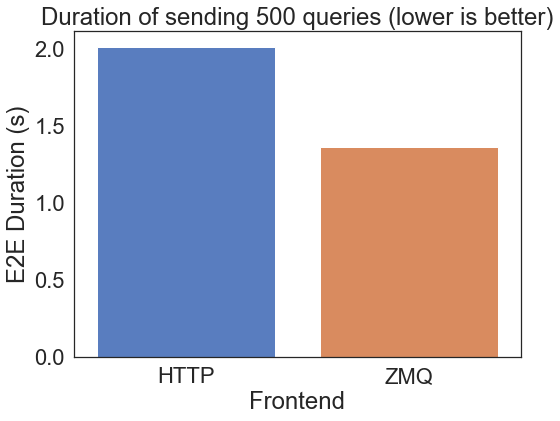

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='Frontend', y='E2E Duration (s)')
plt.title("Duration of sending 500 queries (lower is better)")
plt.savefig('/Users/rehandurrani/Desktop/dur_cmp.svg')

<BarContainer object of 2 artists>

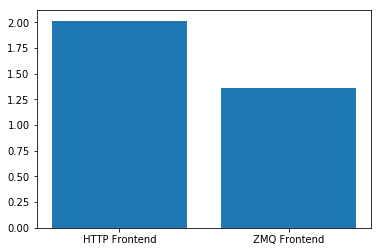

In [13]:
plt.bar(['HTTP Frontend', "ZMQ Frontend"], [avg_http[-1], avg_zmq[-1]])

In [49]:
latencies = np.load('latencies_single_query.npy')

In [50]:
latencies

array([[0.00311723, 0.00260165, 0.00214984, ..., 0.00217718, 0.00223817,
        0.00222012],
       [0.00216001, 0.00221913, 0.00276052, ..., 0.00221811, 0.00221291,
        0.0022004 ],
       [0.00216944, 0.002187  , 0.00220403, ..., 0.00223823, 0.00222932,
        0.00252224]])

In [59]:
df = pd.DataFrame(latencies)

In [60]:
df = df.melt().rename(columns={'variable': 'Query ID', 'value': 'Latency (s)'})

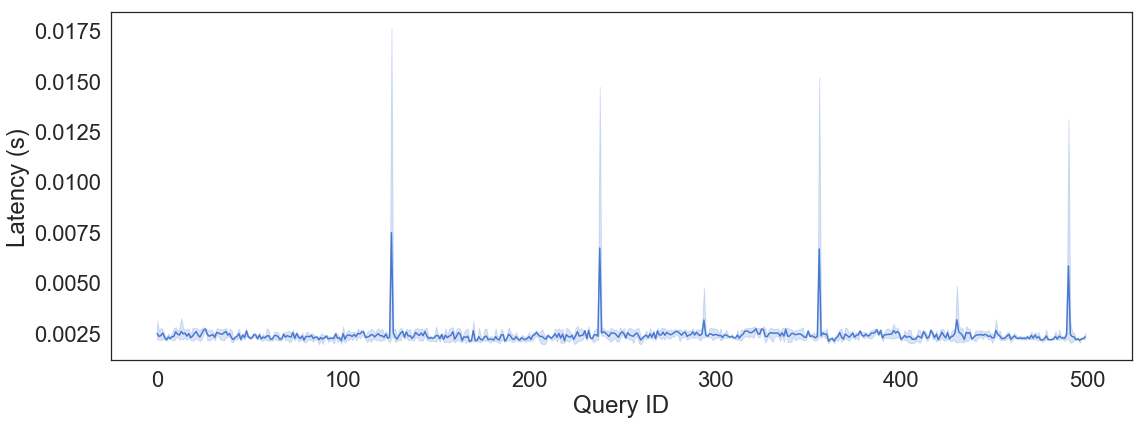

In [71]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='Query ID', y='Latency (s)')
plt.tight_layout()
plt.savefig('/Users/rehandurrani/Desktop/stab_lat.svg')